# 5: Boosting to Uniformity

In physics applications frequently we need to achieve uniformity of predictions along some features.
For instance, when testing for the existence of a new particle, we need a classifier to be uniform in background along the mass (otherwise one can get false discovery due to so-called peaking background).

This notebook contains some comparison of classifiers. The target is to obtain flat effiency in __signal__ (without significally loosing quality of classification) in Dalitz features.

The classifiers compared are 

* plain __GradientBoosting__ 
* __uBoost__
* gradient boosting with knn-Ada loss (__UGB+knnAda__) 
* gradient boosting with FlatnessLoss (__UGB+FlatnessLoss__)

We use dataset from paper about `uBoost` for demonstration purposes.
We have a plenty of data here, so results are quite stable

In [51]:
import pandas, numpy
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
# this wrapper makes it possible to train on subset of features
from matplotlib import pyplot as plt
from hep_ml.commonutils import train_test_split
from hep_ml import uboost, gradientboosting as ugb, losses

### Loading data

In [52]:
import uproot4
import awkward as ak
used_columns = ["Y1", "Y2", "Y3", "M2AB", "M2AC"]
data = uproot4.open('https://cern.ch/starterkit/data/advanced-python-2019/dalitzdata.root',
                   httpsource={'chunkbytes': 1024*1024, 'limitbytes': 33554432, 'parallel': 64})['tree']

data =data.arrays(data.keys())
data = ak.to_pandas(data)
labels = data['labels']
data = data.drop('labels', axis=1)

## Distributions in the Dalitz features for signal and background
As we can see, the background is distributed mostly in the corners of Dalitz plot, <br />
and for traditional classifiers this results in poor effieciency of signal in the corners.

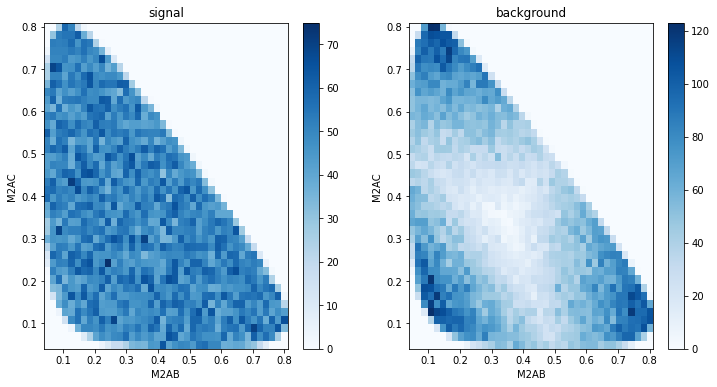

In [53]:
def plot_distribution(data_frame, var_name1='M2AB', var_name2='M2AC', bins=40):
    """The function to plot 2D distribution histograms"""
    plt.hist2d(data_frame[var_name1], data_frame[var_name2], bins = 40, cmap=plt.cm.Blues)
    plt.xlabel(var_name1)
    plt.ylabel(var_name2)
    plt.colorbar()

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1), plt.title("signal"),       plot_distribution(data[labels==1])
plt.subplot(1, 2, 2), plt.title("background"),   plot_distribution(data[labels==0])
pass

## Preparation of train/test datasets

In [54]:
trainX, testX, trainY, testY = train_test_split(data, labels, random_state=42, test_size=0.5)

## Setting up classifiers, training

In [55]:
uniform_features  = ["M2AB", "M2AC"]
train_features = ["Y1", "Y2", "Y3"]
n_estimators = 150
base_estimator = DecisionTreeClassifier(max_depth=4)

__uBoost__ training takes much time, so we reduce number of efficiency_steps, use prediction smoothing and run uBoost in threads

In [ ]:
classifiers = {}

classifiers['AdaBoost'] = GradientBoostingClassifier(max_depth=4, n_estimators=n_estimators, learning_rate=0.1)


knnloss = ugb.KnnAdaLossFunction(uniform_features, knn=10, uniform_label=1)
classifiers['uGB+knnAda'] = ugb.UGradientBoostingClassifier(loss=knnloss, max_depth=4, n_estimators=n_estimators,
                                        learning_rate=0.4, train_features=train_features)

classifiers['uBoost'] = uboost.uBoostClassifier(uniform_features=uniform_features, uniform_label=1,
                                     base_estimator=base_estimator, 
                                     n_estimators=n_estimators, train_features=train_features, 
                                     efficiency_steps=12, n_threads=4)

flatnessloss = ugb.KnnFlatnessLossFunction(uniform_features, fl_coefficient=3., power=1.3, uniform_label=1)
classifiers['uGB+FL'] = ugb.UGradientBoostingClassifier(loss=flatnessloss, max_depth=4, 
                                       n_estimators=n_estimators, 
                                       learning_rate=0.1, train_features=train_features)

for clf in classifiers.values():
    if clf==classifiers['AdaBoost']:
        clf.fit(trainX[train_features], trainY)
    else:
        clf.fit(trainX[train_features + uniform_features], trainY)


## Let's look at the results of training

dependence of classification quality on the number of trees built (ROC AUC - an area under the ROC curve, the more the better)

In [ ]:
from sklearn.metrics import roc_auc_score

for clf in classifiers.values():
    if clf==classifiers['AdaBoost']:
        output = clf.predict_proba(trainX[train_features])
    else:
        output = clf.predict_proba(trainX[train_features + uniform_features])
    print('Area under curve: {}'.format(roc_auc_score(trainY, output[:,1])))

## ROC curves after training

In [ ]:
from sklearn.metrics import roc_curve

def plot_roc(bdt, testY, testX, training_columns, label=None):
    y_score = bdt.predict_proba(testX[training_columns])[:,1]
    fpr, tpr, thresholds = roc_curve(testY, y_score)
    area = roc_auc_score(testY, y_score)
    plt.grid()

    plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
    if label:
        plt.plot(fpr, tpr, label=f'{label} (area = {area:.2f})')
    else:
        plt.plot(fpr, tpr, label=f'ROC curve (area = {area:.2f})')
    plt.xlim(0.0, 1.0)
    plt.ylim(0.0, 1.0)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    # We can make the plot look nicer by forcing the grid to be square
    plt.gca().set_aspect('equal', adjustable='box')

plt.figure(figsize=(8,8))
plot_roc(classifiers['AdaBoost'], testY, testX, train_features, 'AdaBoost')
plot_roc(classifiers['uGB+knnAda'], testY, testX, train_features+uniform_features, 'uGB+knnAda')
plot_roc(classifiers['uBoost'], testY, testX, train_features+uniform_features, 'uBoost')
plot_roc(classifiers['uGB+FL'], testY, testX, train_features+uniform_features, 'uGB+FL')
    